In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [28]:
import pickle
from torchvision.transforms import Compose, ToTensor
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import EWC
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [29]:
import sys
sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH

# Dataset and definitions

## Preprocessing definitions

In [7]:
train_transform = Compose([
    ToTensor(),
])

test_transform = Compose([
    ToTensor(),
])

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [8]:
# mnist_train = MNIST(DATASETS_PATH, train=True, download=True, transform=train_transform)
# mnist_test = MNIST(DATASETS_PATH, train=False, download=True, transform=test_transform)

scenario = PermutedMNIST(10, seed=1234, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [9]:
# scenario = nc_benchmark(
#     mnist_train, mnist_test,
#     n_experiences=len(mnist_train.classes), shuffle=True, seed=1234, task_labels=False
# )

train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [10]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()]
)

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [11]:
# model = MLP(n_classes=scenario.n_classes, n_channels=1, width=28, height=28)
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28*28, hidden_layers=2, hidden_size=100, drop_rate=0)
optimizer = SGD(model.parameters(), lr=1e-3)
criterion = CrossEntropyLoss()
strategy = EWC(
    model, optimizer, criterion, ewc_lambda=1.0, train_epochs=5, train_mb_size=256, evaluator=eval_plugin, mode="separate", eval_mb_size=128
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

In [12]:
results = list()

for experience in tqdm(train_stream):
    strategy.train(experience)
    metrics = strategy.eval(test_stream)
    results.append(metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 67.55it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:03<00:00, 72.12it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:03<00:00, 74.40it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:03<00:00, 75.44it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:03<00:00, 72.93it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 146.79it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6745
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 144.64it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.1313
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 147.70it/s]
> Eval

 10%|█         | 1/10 [00:24<03:40, 24.45s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1599
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2070
-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 71.06it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:03<00:00, 71.05it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:03<00:00, 71.43it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:03<00:00, 71.14it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:03<00:00, 69.84it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 148.55it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5923
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 149.34it/s]
> Eval on experience 1 (Task 

 20%|██        | 2/10 [00:49<03:16, 24.59s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1901
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2880
-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 68.84it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:03<00:00, 69.57it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:03<00:00, 68.76it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:03<00:00, 69.30it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:03<00:00, 68.15it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 147.33it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6329
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 147.46it/s]
> Eval on experience 1 (Task 

 30%|███       | 3/10 [01:14<02:54, 24.93s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1986
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.3496
-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 65.74it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:03<00:00, 66.17it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:03<00:00, 65.97it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:03<00:00, 65.67it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:03<00:00, 65.89it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 145.50it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5192
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 150.94it/s]
> Eval on experience 1 (Task 

 40%|████      | 4/10 [01:40<02:32, 25.38s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1771
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.3873
-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 64.78it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:03<00:00, 64.31it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:03<00:00, 64.34it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:03<00:00, 64.30it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:03<00:00, 63.87it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 143.59it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6163
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 149.44it/s]
> Eval on experience 1 (Task 

 50%|█████     | 5/10 [02:06<02:08, 25.75s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1734
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4487
-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 60.25it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:03<00:00, 59.32it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:03<00:00, 59.72it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:03<00:00, 60.07it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:03<00:00, 60.36it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 138.45it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5891
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 145.88it/s]
> Eval on experience 1 (Task 

 60%|██████    | 6/10 [02:35<01:46, 26.60s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1592
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5039
-- >> Start of training phase << --
100%|██████████| 235/235 [00:04<00:00, 56.33it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:03<00:00, 59.93it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:04<00:00, 58.71it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:04<00:00, 57.81it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:03<00:00, 58.82it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 146.83it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5956
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 146.57it/s]
> Eval on experience 1 (Task 

 70%|███████   | 7/10 [03:03<01:21, 27.25s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1460
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5505
-- >> Start of training phase << --
100%|██████████| 235/235 [00:04<00:00, 55.68it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:04<00:00, 57.95it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:04<00:00, 57.52it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:03<00:00, 59.37it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:04<00:00, 56.94it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 144.33it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5647
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 143.01it/s]
> Eval on experience 1 (Task 

 80%|████████  | 8/10 [03:32<00:55, 27.81s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1578
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5938
-- >> Start of training phase << --
100%|██████████| 235/235 [00:04<00:00, 54.96it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:04<00:00, 53.70it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:04<00:00, 54.92it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:04<00:00, 55.07it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:04<00:00, 55.09it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 138.96it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5178
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 136.54it/s]
> Eval on experience 1 (Task 

 90%|█████████ | 9/10 [04:02<00:28, 28.50s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1710
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6429
-- >> Start of training phase << --
100%|██████████| 235/235 [00:04<00:00, 53.93it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:04<00:00, 53.43it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:04<00:00, 53.17it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:04<00:00, 53.21it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:04<00:00, 53.82it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 142.41it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5519
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 146.25it/s]
> Eval on experience 1 (Task 

100%|██████████| 10/10 [04:33<00:00, 27.31s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.8034
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6937


In [24]:
accuracies: dict[int, list[float]] = dict()

for i in range(10):
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{i}"][1]

accuracies["Overall"] = eval_plugin.get_all_metrics()["Top1_Acc_Stream/eval_phase/test_stream/Task000"][1]

In [25]:
acc_df = pd.DataFrame(accuracies)
acc_df.index = range(10)

<Axes: >

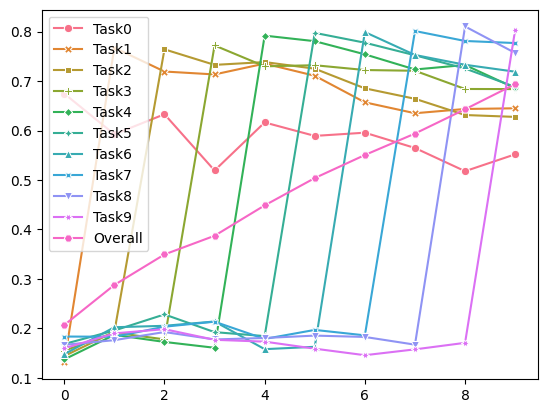

In [27]:
# lineplot every task acc per training
sns.lineplot(data=acc_df, dashes=False, markers=True)

# Store metrics

In [30]:
pickle.dump(acc_df, open(SAVED_METRICS_PATH / "ewc.pkl", "wb"))